# Data Cleaning

For each IMU file, clean the IMU data, adjust the labels, and output these as CSV files.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
import joblib

from src.data.labels_util import load_labels, LabelCol, get_labels_file, load_clean_labels
from src.data.imu_util import (
    get_sensor_file, ImuCol, load_imu_data, Sensor, fix_epoch, resample_uniformly, time_to_row_range, get_data_chunk,
    normalize_with_bounds, data_to_features, list_imu_abspaths, clean_imu_data
)
from src.data.util import find_nearest, find_nearest_index, shift, low_pass_filter, add_col
from src.data.workout import Activity
from src.data.data import DataState
from src.data.make_dataset import main as make_dataset
from src.data.make_labels import main as make_labels
from src.visualization.visualize import multiplot

# import data types
from pandas import DataFrame
from numpy import ndarray
from typing import List, Tuple, Optional

## Clean IMU data

Cleaning file '10L_2020-08-13T09.44.56.359_D592640E9A77_Accelerometer.csv'...
Cleaning file '17R_2020-08-13T10.34.27.662_F7025F7111F1_Accelerometer.csv'...
Cleaning file '11L_2020-08-13T09.48.23.503_E8E376103A59_Accelerometer.csv'...
Cleaning file '16R_2020-08-13T10.51.24.151_F14724A81B5E_Accelerometer.csv'...
Cleaning file '4R_2020-08-13T09.37.23.452_C47D949C3933_Accelerometer.csv'...
Cleaning file '12L_2020-08-13T14.54.40.903_FD3613415C08_Accelerometer.csv'...
Cleaning file '9L_2020-08-13T09.45.57.395_C9936E243F1B_Accelerometer.csv'...
Cleaning file '1R_2020-08-12T10.42.36.957_E6506ED62C8A_Accelerometer.csv'...
Cleaning file '9R_2020-08-09T15.16.11.857_DC1A3C126A85_Accelerometer.csv'...
Cleaning file '14L_2020-08-13T09.43.57.053_DFA47D398ABD_Accelerometer.csv'...
Cleaning file '7R_2020-08-13T09.40.34.504_D04FC054D444_Accelerometer.csv'...
Cleaning file '1L_2020-08-12T14.17.19.067_DC5656563C03_Accelerometer.csv'...
Cleaning file '15R_2020-08-13T09.48.26.452_E4A89F39693B_Accelerometer.

<IPython.core.display.Javascript object>


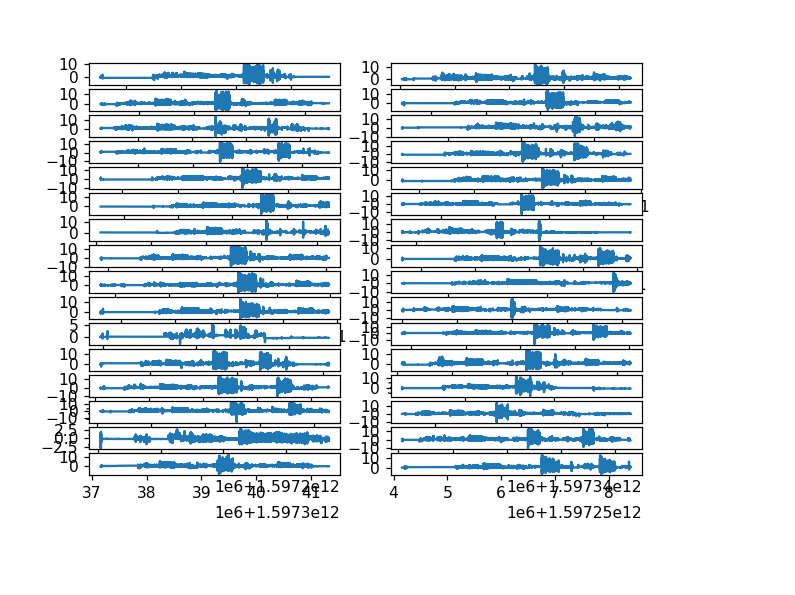

In [2]:
# Clean data (Uncomment when needed)
# make_dataset()

# Test
cleaned_files = list_imu_abspaths(sensor_type=Sensor.Accelerometer, data_state=DataState.Clean)

def plot_helper(idx, plot):
    imu_data = np.load(cleaned_files[idx])
    plot.plot(imu_data[:, ImuCol.TIME], imu_data[:, ImuCol.XACCEL])
#     plot.plot(imu_data[:, ImuCol.TIME], imu_data[:, ImuCol.YACCEL])
#     plot.plot(imu_data[:, ImuCol.TIME], imu_data[:, ImuCol.ZACCEL])
    
multiplot(len(cleaned_files), plot_helper)

## Adjust Labels

In [4]:
# Adjust labels (Uncomment when needed)
# make_labels()

# Test
raw_boot_labels = load_labels(get_labels_file(Activity.Boot, DataState.Raw), Activity.Boot)
raw_pole_labels = load_labels(get_labels_file(Activity.Pole, DataState.Raw), Activity.Pole)
clean_boot_labels = load_clean_labels(Activity.Boot)
clean_pole_labels = load_clean_labels(Activity.Pole)

# print('Raw Boot')
# print(raw_boot_labels[:50,])
# print('Clean Boot')
# print(clean_boot_labels[:50,])
# print('Raw Pole')
# print(raw_pole_labels[:50,])
# print('Clean Pole')
# print(clean_pole_labels[:50,])